# Person Re-ID

## Importing

In [1]:
import copy
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import time
import warnings
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import scipy.io

from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from typing import List, Tuple

## Inspecting the dataset

This package contains the following items.
1. Folder "frames". It contains 11,816 video frames captured by 6 cameras. For the naming rule of each frame, for example, in "c1s1_000151.jpg", "c1" refers to camera 1; "s1" refers to segment 1 in camera 1 (generated automatically during data collection); "000151" refers to the 151th frame in this segment. In addition, the train/test split is FIXED and provided by the files "frame_test.mat" and "frame_train.mat". 10-fold cross validation is NOT required.

2. Folder "annotations". It contains 11,816 MAT files in correspondence to each frame in folder "frames". All annotated boxes are pedestrians. Each MAT file records the bounding box position within the frame and its ID. The coordinates of each box are formatted in [x, y, w, h]. The ID of each box takes the value of [1, 932] as well as -2. "-2" means that we do not know for sure the ID of the person, and not used in the testing of person re-id, but is used in train/test of pedestrian detection (potentially used in the training of person re-identification).

3. Folder "query_box". It contains the query boxes of the PRW dataset. All togther there are 2057 queries. For naming rule, for example, in "479_c1s3_016471.jpg", "479" refers to the ID of the query, and "c1s3_016471" refers to the video frame where the query is cropped. Note that 1) the query IDs are not included in the training set, 2) the query images are not normalized (we typically use 128*64 for BoW extraction, and 224*224 for CNN feature extraction), 3) all queries are hand-drawn boxes, 4) we select one query image for each testing ID under each camera, so the maximum number of queries per ID is 6. In addition, we provide the bounding box information of each query in "query_info.txt", so one can generate the queries from the video frames through function "generate_query.m".

In addition, we provide the train/test split of the PRW dataset. One do not have to perform 10-fold cross validation. In detail, "frame_test.mat" and "frame_train.mat" specify the train/test frames, and "ID_test.mat" and "ID_train.mat" specify the train/test IDs. Note that a small portion of IDs used in training may appear in the testing frames, but will not appear in the testing IDs. 

What basic tasks can you do with PRW?
1. Pedestrian detection. Models can be trained on the training set specified in "frame_train" and tested on "frame_test". In the paper, we report both Average Precision and Miss Rate for pedestrian detection.

2. Person Re-identification. When you use your own detector or those provided by us, you will obtain your own gallery with varying sizes according to the threshold of the detectors. Then, with the given query images, standard person re-identification can be performed. We use mAP and CMC curve (and rank-1 accuracy) to evaluate overall re-identification performance. Note that, when your detector has poor performance, re-id accuracy will be low as a result. 

In [5]:
print("Num. frames:", len(os.listdir("/kaggle/input/datasets/edoardomerli/prw-person-re-identification-in-the-wild/frames")))
print("Num. queries:", len(os.listdir("/kaggle/input/datasets/edoardomerli/prw-person-re-identification-in-the-wild/query_box")))

Num. frames: 11816
Num. queries: 2057


In [6]:
all_imgs_path = "/kaggle/input/datasets/edoardomerli/prw-person-re-identification-in-the-wild/frames"
list_imgs = os.listdir(all_imgs_path)
list_sizes = []

for img_path in list_imgs:
    img = Image.open(os.path.join(all_imgs_path, img_path))
    list_sizes.append(img.size)

In [9]:
all_queries_path = "/kaggle/input/datasets/edoardomerli/prw-person-re-identification-in-the-wild/query_box"
list_queries = os.listdir(all_queries_path)
list_sizes_q = []

for q_path in list_queries:
    q = Image.open(os.path.join(all_queries_path, q_path))
    list_sizes_q.append(q.size)

In [10]:
print(f"Frame sizes: {set(list_sizes)}")
print(f"Query sizes (first ten): {list_sizes_q[:10]}") 

Frame sizes: {(1920, 1080), (720, 576)}
Query sizes: [(78, 186), (48, 116), (48, 127), (36, 112), (143, 356), (225, 420), (50, 151), (176, 551), (88, 249), (302, 670)]


---- IMAGE STATS ----
#Images: 11816
Mean size: 1625.7 x 956.4
Min size: 720 x 576
Max size: 1920 x 1080


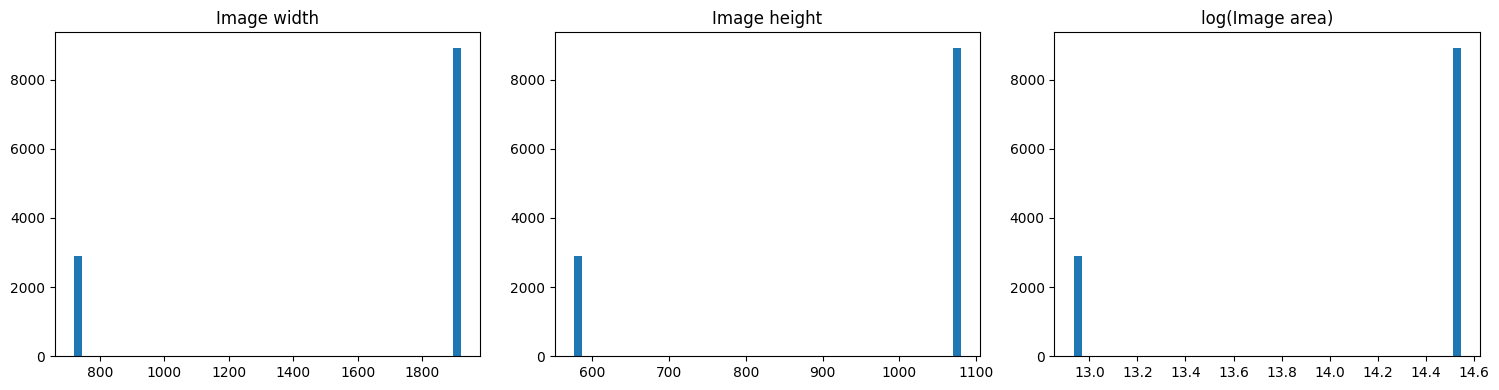

In [11]:
widths = [s[0] for s in list_sizes]
heights = [s[1] for s in list_sizes]
areas = [w*h for w,h in list_sizes]

print("---- IMAGE STATS ----")
print(f"#Images: {len(list_sizes)}")
print(f"Mean size: {np.mean(widths):.1f} x {np.mean(heights):.1f}")
print(f"Min size: {min(widths)} x {min(heights)}")
print(f"Max size: {max(widths)} x {max(heights)}")

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.hist(widths, bins=50)
plt.title("Image width")

plt.subplot(1,3,2)
plt.hist(heights, bins=50)
plt.title("Image height")

plt.subplot(1,3,3)
plt.hist(np.log1p(areas), bins=50)
plt.title("log(Image area)")

plt.tight_layout()
plt.show()

> Frame sizes are just of two different types; query sizes are instead of vary different types

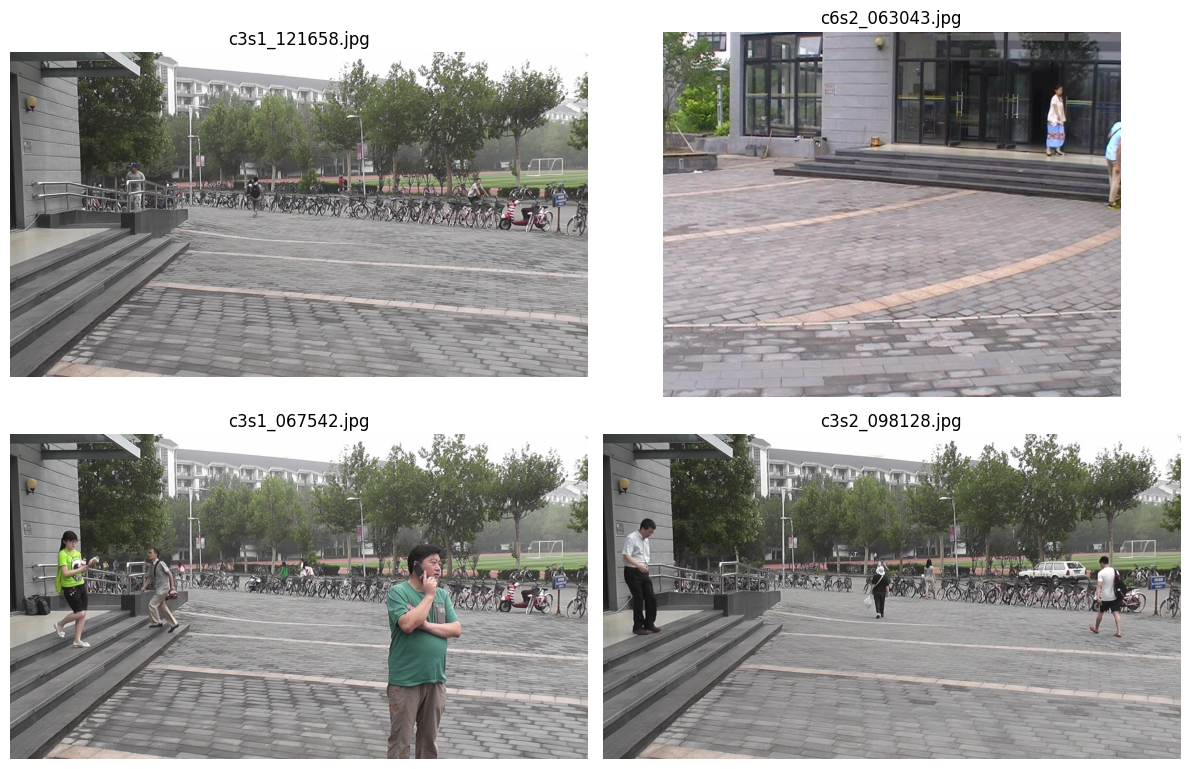

In [20]:
# SHOW RANDOM FRAMES
plt.figure(figsize=(12,8))

for i in range(4):
    img_name = random.choice(list_imgs)
    img = Image.open(os.path.join(all_imgs_path, img_name)).convert("RGB")

    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.title(img_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [24]:
# SHOW ANNOTATIONS
mat = scipy.io.loadmat('/kaggle/input/prw-person-re-identification-in-the-wild/annotations/c1s1_002876.jpg.mat')
print(mat["box_new"]) # [ID, x, y, w, h]

[[  15.         1372.2062635   421.53671706   72.31101512  158.61771058]
 [  25.         1442.18466523  433.19978402   79.30885529  165.61555076]]


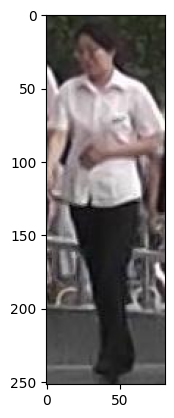

query size: (81, 252)


In [25]:
# SHOW QUERIES
query_path = "/kaggle/input/prw-person-re-identification-in-the-wild/query_box/486_c3s1_157433.jpg"
query = Image.open(query_path)
plt.imshow(query)
plt.show()
print(f"query size: {query.size}")

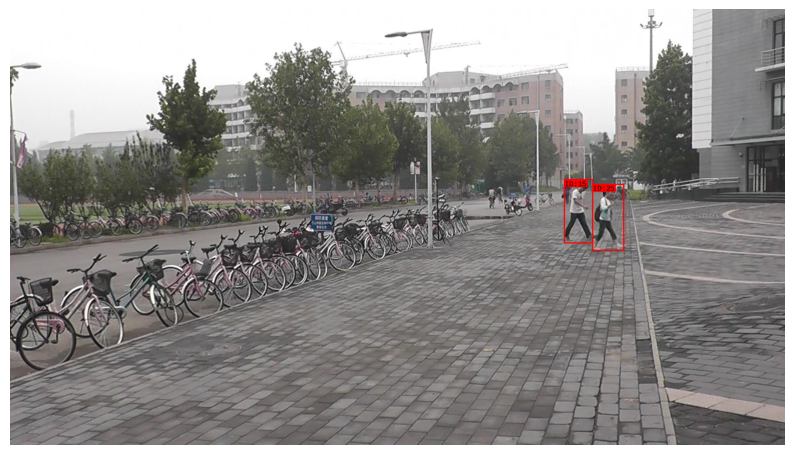

In [6]:
# DRAW BOXES
import numpy as np
import scipy.io
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def draw_prw_box(
    image: Image.Image,
    box_new: np.ndarray,
    show_id: bool = True,
    filter_ids: bool = False,      # se True rimuove ID <= 0 (es. -2)
    color=(255, 0, 0),
    width: int = 3,
) -> Image.Image:
    """
    Draw PRW annotations from mat["box_new"] where each row is [ID, x, y, w, h].
    Coordinates are pixel coords (not normalized).
    """
    img = image.copy()
    draw = ImageDraw.Draw(img)

    # font: su kaggle spesso questa path funziona; se no fallback
    try:
        font = ImageFont.truetype(
            "/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 18
        )
    except Exception:
        font = ImageFont.load_default()

    if box_new is None:
        return img

    box_new = np.asarray(box_new)
    if box_new.size == 0:
        return img

    # TODO - optimize
    # g.t. or re-id case
    if show_id: 
        box_new = box_new.reshape(-1, 5) # Ensure shape [N,5]
    
        for row in box_new:
            pid, x, y, w, h = row.tolist()
    
            if filter_ids and pid <= 0:
                continue
    
            # xywh -> xyxy
            x1, y1 = float(x), float(y)
            x2, y2 = float(x + w), float(y + h)
    
            # draw rectangle
            draw.rectangle([x1, y1, x2, y2], outline=color, width=width)
    
            text = f"ID:{int(pid)}"
            # text bg
            tw, th = font.getbbox(text)[-2:]
            pad = 2
            draw.rectangle([x1, y1, x1 + tw + 2*pad, y1 + th + 2*pad], fill=color)
            draw.text((x1 + pad, y1 + pad), text, fill="black", font=font)
            
    else: # detection case 
        box_new = box_new.reshape(-1, 4) # Ensure shape [N,4]
    
        for row in box_new:
            x, y, w, h = row.tolist()
    
            if filter_ids and pid <= 0:
                continue
    
            # xywh -> xyxy
            x1, y1 = float(x), float(y)
            x2, y2 = float(x + w), float(y + h)
    
            # draw rectangle
            draw.rectangle([x1, y1, x2, y2], outline=color, width=width)
    
            # text bg
            pad = 2 
            draw.rectangle([x1, y1, x1 + 2*pad, y1 + 2*pad], fill=color)

    return img


# --- Usage ---
img_path = "/kaggle/input/prw-person-re-identification-in-the-wild/frames/c1s1_002876.jpg"
mat_path = "/kaggle/input/prw-person-re-identification-in-the-wild/annotations/c1s1_002876.jpg.mat"

img = Image.open(img_path).convert("RGB")
mat = scipy.io.loadmat(mat_path)
box_new = mat["box_new"]  # rows: [ID, x, y, w, h]

img_bb = draw_prw_box(img, box_new, show_id=True, filter_ids=False)

plt.figure(figsize=(10, 6))
plt.imshow(img_bb)
plt.axis("off")
plt.show()

In [15]:
# PRINT TRAIN/TEST FRAMES AND IDs (distribution)
frame_train = scipy.io.loadmat("/kaggle/input/datasets/edoardomerli/prw-person-re-identification-in-the-wild/frame_train.mat")
id_train = scipy.io.loadmat('/kaggle/input/datasets/edoardomerli/prw-person-re-identification-in-the-wild/ID_train.mat')
print("TRAIN")
print("Frames:", frame_train["img_index_train"].shape) 
print("ID:", id_train["ID_train"].shape)

frame_test = scipy.io.loadmat("/kaggle/input/datasets/edoardomerli/prw-person-re-identification-in-the-wild/frame_test.mat")
id_test = scipy.io.loadmat('/kaggle/input/datasets/edoardomerli/prw-person-re-identification-in-the-wild/ID_test.mat')
print("\nTEST")
print("Frames:", frame_test["img_index_test"].shape) 
print("IDs:", id_test["ID_test2"].shape)

TRAIN
Frames: (5704, 1)
ID: (1, 483)

TEST
Frames: (6112, 1)
IDs: (1, 450)


In [18]:
from collections import Counter

# Query insepction
query_dir = "/kaggle/input/datasets/edoardomerli/prw-person-re-identification-in-the-wild/query_box"
query_imgs = os.listdir(query_dir)

print("---- QUERY STATS ----")
print(f"#Query images: {len(query_imgs)}")

# extract pid from filename (format: pid_stem.jpg)
pids = [int(q.split("_")[0]) for q in query_imgs]
print(f"#Unique query identities: {len(set(pids))}")

print("Most frequent query IDs:")
print(Counter(pids).most_common(10))

---- QUERY STATS ----
#Query images: 2057
#Unique query identities: 450
Most frequent query IDs:
[(717, 6), (889, 6), (852, 6), (728, 6), (802, 6), (511, 6), (733, 6), (704, 6), (509, 6), (710, 6)]


> The PRW dataset contains 11,816 frames and 932 unique identities in total, with a clear separation between training and testing identities. The images exhibit moderate resolution variability and significant scene complexity, including crowding and occlusions. The query set consists of cropped person instances, each associated with a specific identity. These characteristics make PRW particularly challenging for both detection and re-identification, motivating the use of robust backbones and discriminative (angular) metric learning losses.